# Analyses de la résilience d'un essaim de nano-satellites

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
from mpl_toolkits import mplot3d
from scipy.spatial.distance import cdist

from swarm_sim import *



%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [2]:
PATH = 'Traces.csv'

df = pd.read_csv(PATH, sep=',', header=None)
satellites = {}

for i in range(0,100):
    sat = df.iloc[3*i : 3*i+3].copy()
    sat['coords'] = ['x','y','z']
    satellites[i] = sat.set_index('coords', drop=True)

satellites[0]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [3]:
RANGE1 = 20000
RANGE2 = 40000
RANGE3 = 60000

list_satellites = []

for i in range(len(satellites)):
    obj_sat = Node.__new__(Node)
    obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])
    list_satellites.append(obj_sat)

swarm = Swarm.__new__(Swarm)
swarm.__init__(RANGE1, list_satellites)
graph1 = swarm.swarm_to_nxgraph()

swarm.__init__(RANGE2, list_satellites)
graph2 = swarm.swarm_to_nxgraph()

swarm.__init__(RANGE3, list_satellites)
graph3 = swarm.swarm_to_nxgraph()

/tmp/ipykernel_16366/233490362.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])


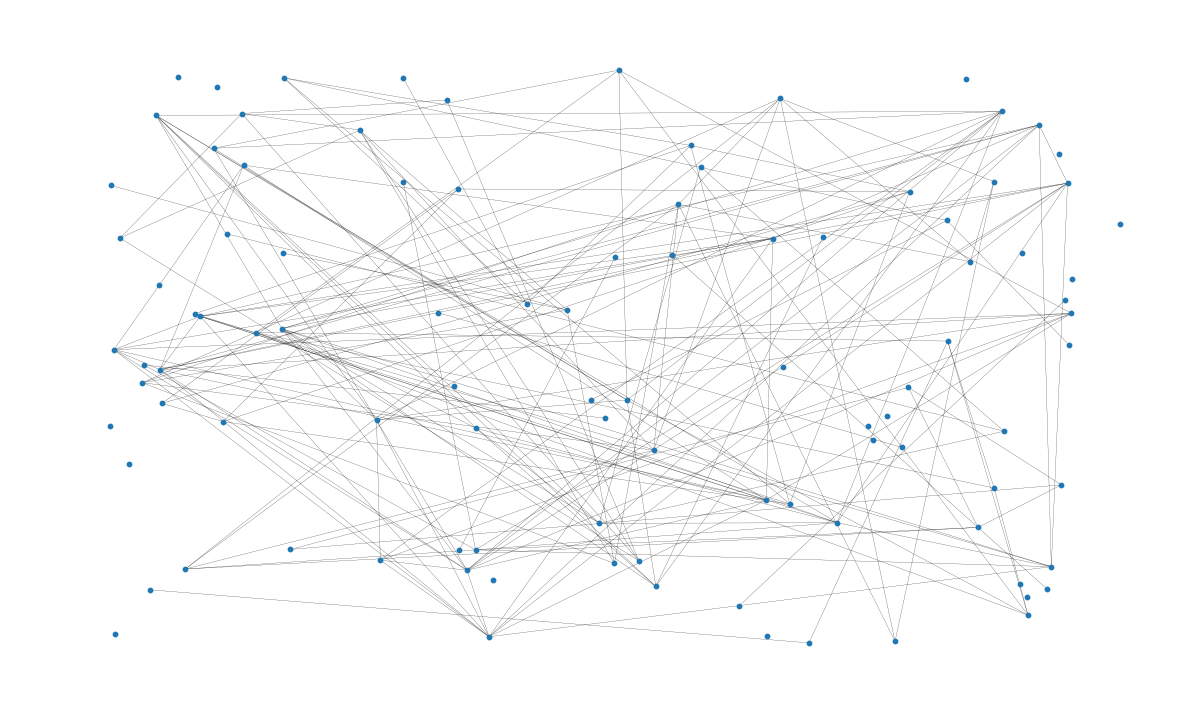

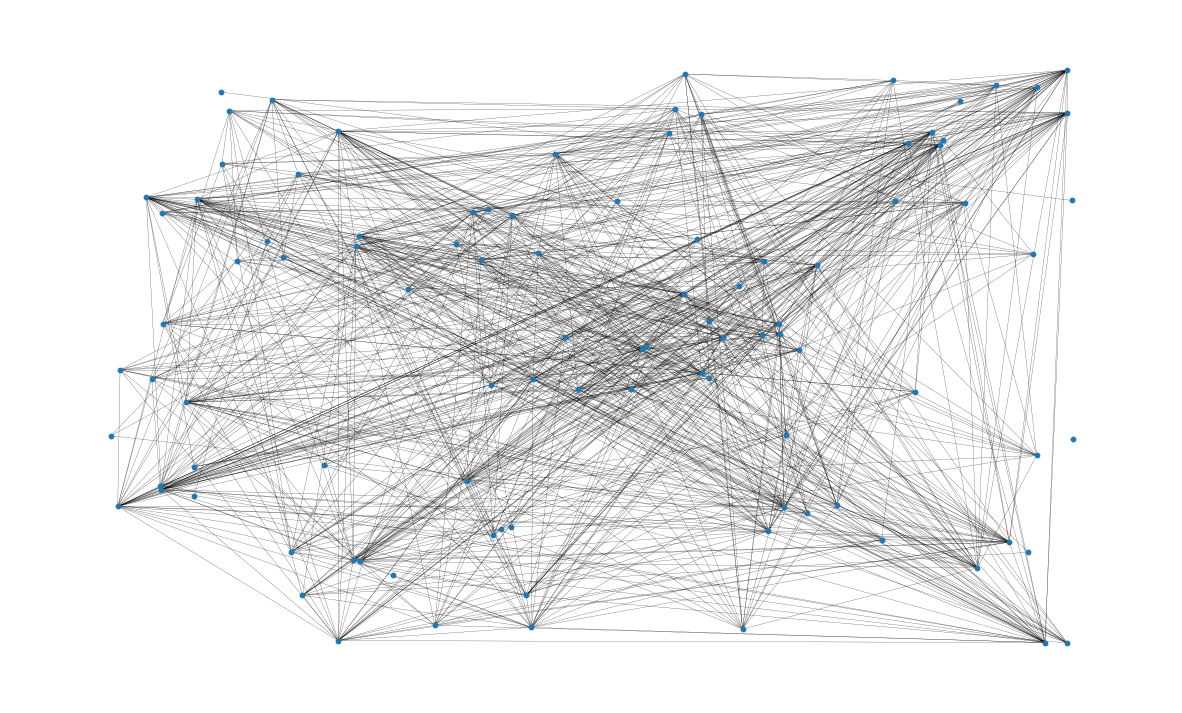

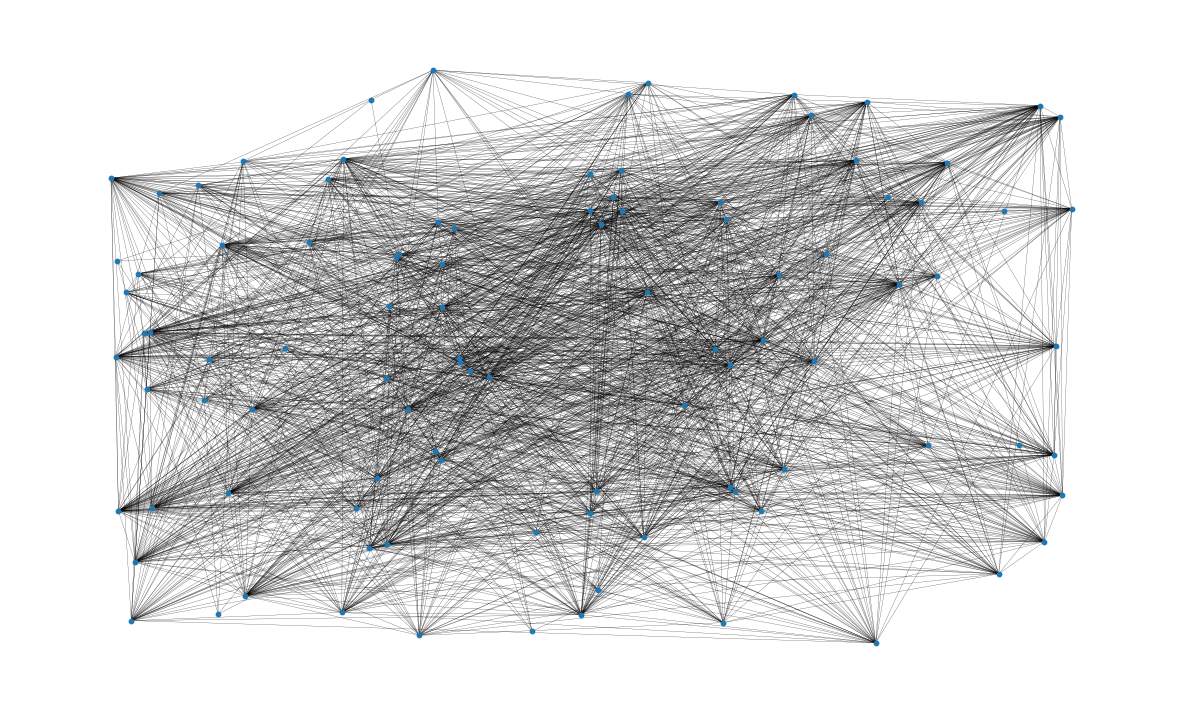

In [5]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
def afficher_graphe(graph):
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")
    nx.draw_networkx(graph, pos=nx.random_layout(graph1), ax=ax, **plot_options)

afficher_graphe(graph1) #arc si distance < 20km
afficher_graphe(graph2) #arc si distance < 40km
afficher_graphe(graph3) #arc si distance < 60km

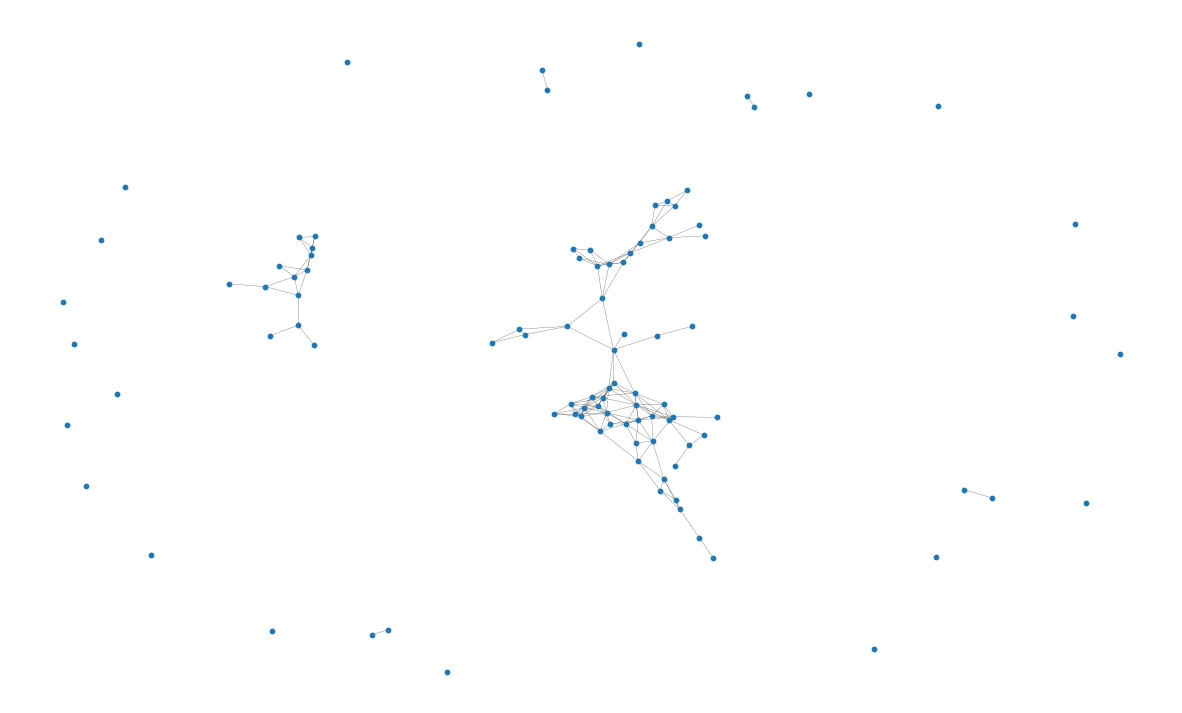

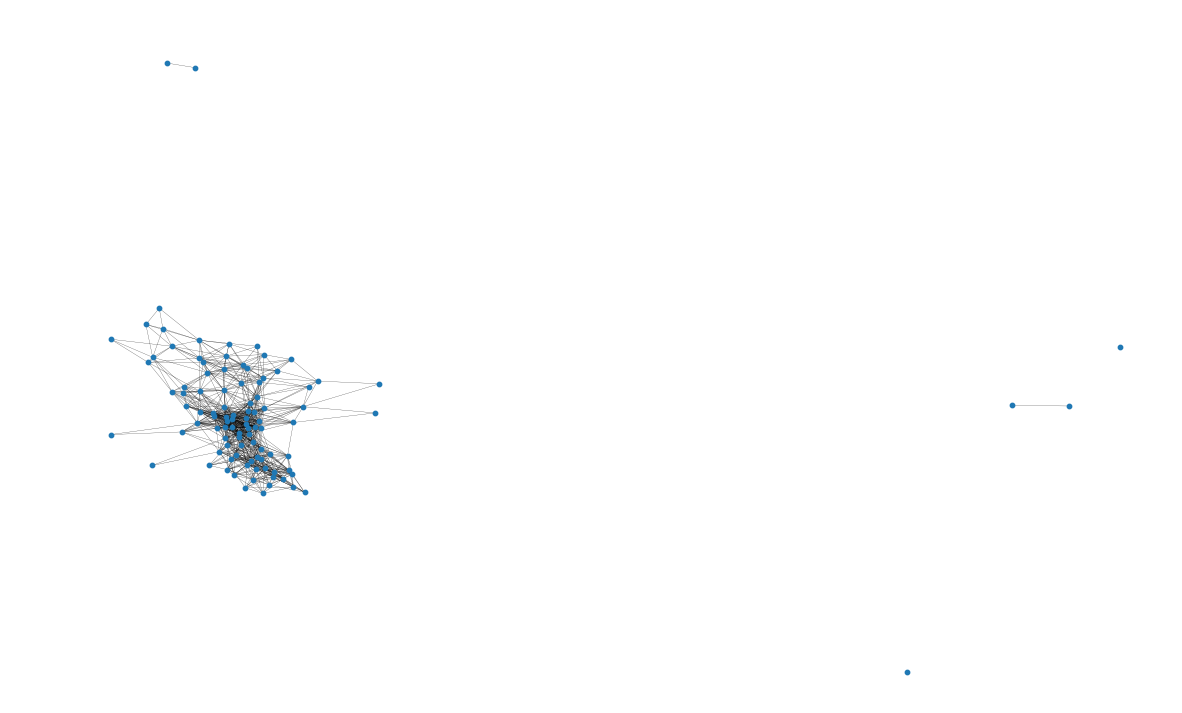

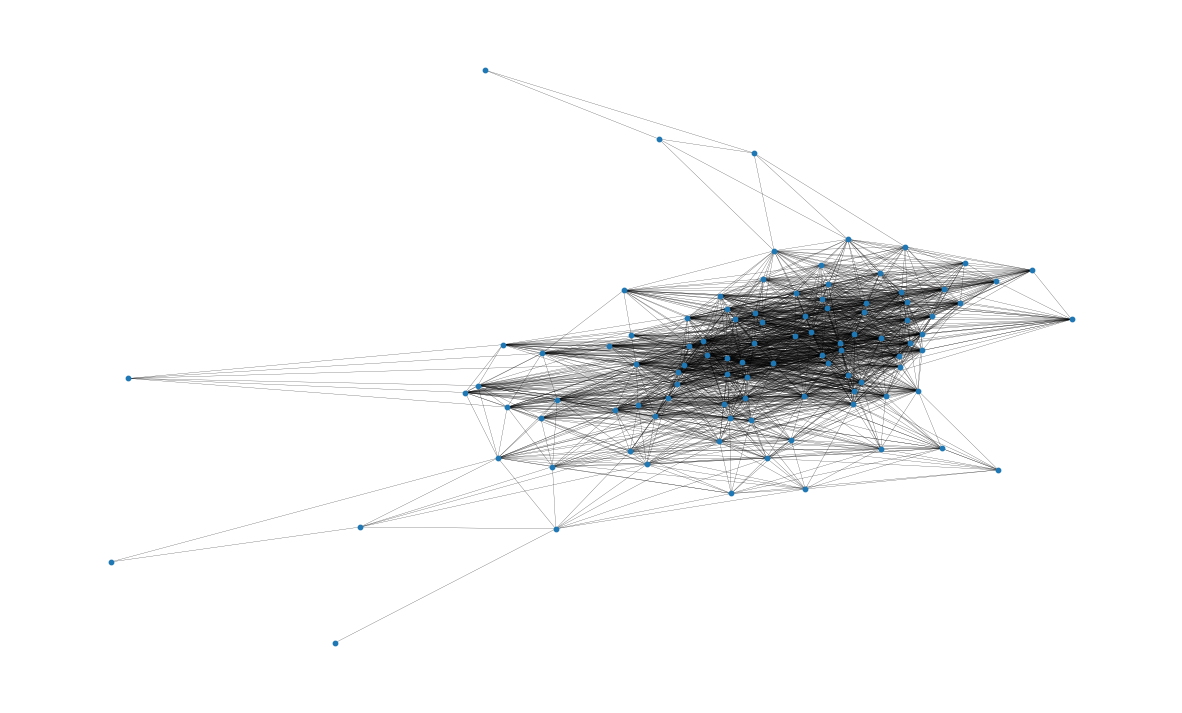

In [8]:
def afficher_graphe_avec_layout(graph):
    pos = nx.spring_layout(graph)
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")
    nx.draw_networkx(graph, pos=pos, ax=ax, **plot_options)

afficher_graphe_avec_layout(graph1) #arc si distance < 20km
afficher_graphe_avec_layout(graph2) #arc si distance < 40km
afficher_graphe_avec_layout(graph3) #arc si distance < 60km

## Robert Ludo

Voir si on supprime un nanosatellite qu'est ce que ça fait

In [18]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

def analyse_graphique_impact_df(PATH='Traces.csv', timestep=0, nb_to_remove=5, range_km=60.0, seed=None,
                                 NodeClass=None, SwarmClass=None, targeted=False, centrality=False, display=True):
    """
    Analyse graphique avec retour sous forme de DataFrame des métriques réseau avant/après suppression de satellites.

    Paramètres :
        - PATH : chemin vers le fichier CSV
        - timestep : temps à analyser (entre 0 et 9999)
        - nb_to_remove : nombre de satellites à supprimer
        - range_km : distance max pour la connexion (en km)
        - seed : graine pour reproductibilité
        - NodeClass : classe Node
        - SwarmClass : classe Swarm
        - targeted : True pour supprimer les plus connectés
        - centrality : True pour supprimer les plus centraux
        - display : affiche les graphes avant/après

    Retour :
        - DataFrame avec les métriques avant/après et la liste des satellites supprimés
    """
    random.seed(seed)
    RANGE = range_km * 1000  # conversion km -> m

    # Lecture du CSV
    df = pd.read_csv(PATH, sep=',', header=None)
    satellites = {}
    for i in range(100):
        sat = df.iloc[3*i:3*i+3].copy()
        sat['coords'] = ['x','y','z']
        satellites[i] = sat.set_index('coords', drop=True)

    list_satellites = []
    for i in range(len(satellites)):
        obj_sat = NodeClass.__new__(NodeClass)
        obj_sat.__init__(i, satellites[i][timestep][0], satellites[i][timestep][1], satellites[i][timestep][2])
        list_satellites.append(obj_sat)

    swarm = SwarmClass.__new__(SwarmClass)
    swarm.__init__(RANGE, list_satellites)
    graph_full = swarm.swarm_to_nxgraph()

    # Sélection des nœuds à supprimer
    if targeted:
        degrees = dict(graph_full.degree)
        to_remove = sorted(degrees, key=degrees.get, reverse=True)[:nb_to_remove]
    elif centrality:
        centrals = nx.betweenness_centrality(graph_full)
        to_remove = sorted(centrals, key=centrals.get, reverse=True)[:nb_to_remove]
    else:
        to_remove = random.sample(list(graph_full.nodes), nb_to_remove)

    graph_reduced = graph_full.copy()
    graph_reduced.remove_nodes_from(to_remove)

    # Fonction pour calculer les métriques
    def compute_metrics(G):
        return {
            "nb_nodes": G.number_of_nodes(),
            "nb_edges": G.number_of_edges(),
            "connectivity": nx.number_connected_components(G),
            "avg_degree": (sum(dict(G.degree).values()) / G.number_of_nodes()) if G.number_of_nodes() > 0 else 0,
            "avg_path_length": nx.average_shortest_path_length(G) if nx.is_connected(G) and G.number_of_nodes() > 1 else None
        }

    metrics_before = compute_metrics(graph_full)
    metrics_after = compute_metrics(graph_reduced)

    # Affichage des graphes
    if display:
        pos = nx.spring_layout(graph_full, iterations=15, seed=1721)
        fig, axs = plt.subplots(1, 2, figsize=(18, 9))
        for ax, G, title in zip(axs, [graph_full, graph_reduced], ["Avant panne", "Après panne"]):
            ax.axis("off")
            nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.15)
            ax.set_title(f"{title} — {range_km} km", fontsize=14)

    # Création DataFrame final
    df_result = pd.DataFrame([
        {"metric": k,
         "before": metrics_before[k],
         "after": metrics_after[k],
         "delta": (metrics_after[k] - metrics_before[k]) if metrics_after[k] is not None and metrics_before[k] is not None else None}
        for k in metrics_before
    ])
    df_result["removed_nodes"] = [to_remove] + [None] * (len(df_result) - 1)
    return df_result


/tmp/ipykernel_18212/3207768247.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_sat.__init__(i, satellites[i][timestep][0], satellites[i][timestep][1], satellites[i][timestep][2])


,metric,before,after,delta,removed_nodes
0,nb_nodes,100.00,80.000,-20.000,"[81, 14, 3, 94, 35, 31, 28, 17, 13, 86, 69, 11..."
1,nb_edges,174.00,107.000,-67.000,None
2,connectivity,26.00,23.000,-3.000,None
3,avg_degree,3.48,2.675,-0.805,None
4,avg_path_length,NaN,NaN,NaN,None


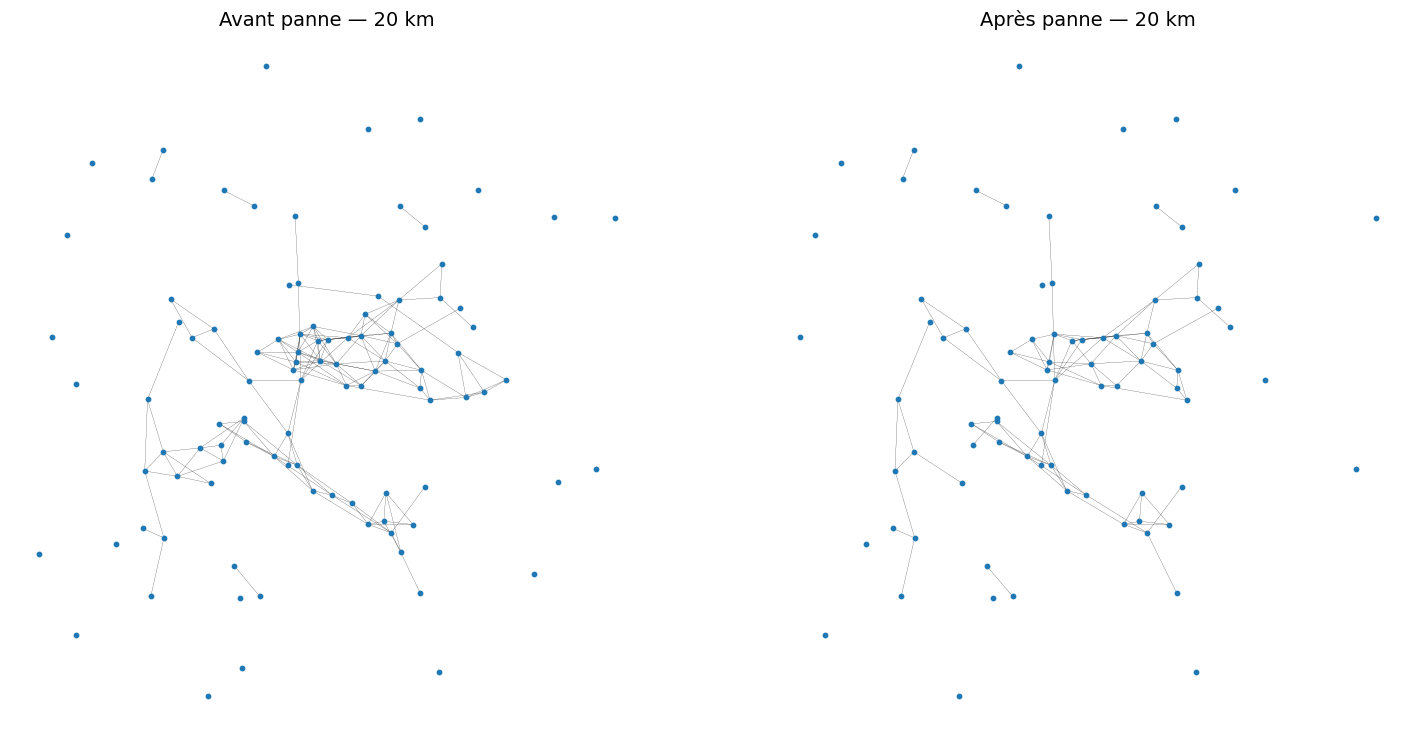

In [23]:
df_metrics = analyse_graphique_impact_df(
    PATH='Traces.csv',
    timestep=0,
    nb_to_remove=20,
    range_km=20,
    seed=42,
    NodeClass=Node,
    SwarmClass=Swarm,
    targeted=False,
    centrality=False,
    display=True
)

df_metrics


# Résilience ciblées

## Analyse de l'impact de la suppression des noeuds à plus haut degré

In [10]:
def list_nodes_high_degree(graph, n):
    """
    Retourne une liste des nœuds avec le plus haut degré dans le graphe donné.

    Paramètres :
        - graph : le graphe à analyser
        - n : nombre de nœuds à retourner

    Retour :
        - Liste des nœuds avec le plus haut degré
    """
    degrees = dict(graph.degree)
    return sorted(degrees, key=degrees.get, reverse=True)[:n]

def delete_nodes(graph, n):
    """
    Supprime une liste de nœuds d'un graphe.

    Paramètres :
        - graph : le graphe à modifier
        - nodes : liste des nœuds à supprimer

    Retour :
        - Graphe modifié
    """
    nodes = list_nodes_high_degree(graph, n)
    graph.remove_nodes_from(nodes)
    return graph

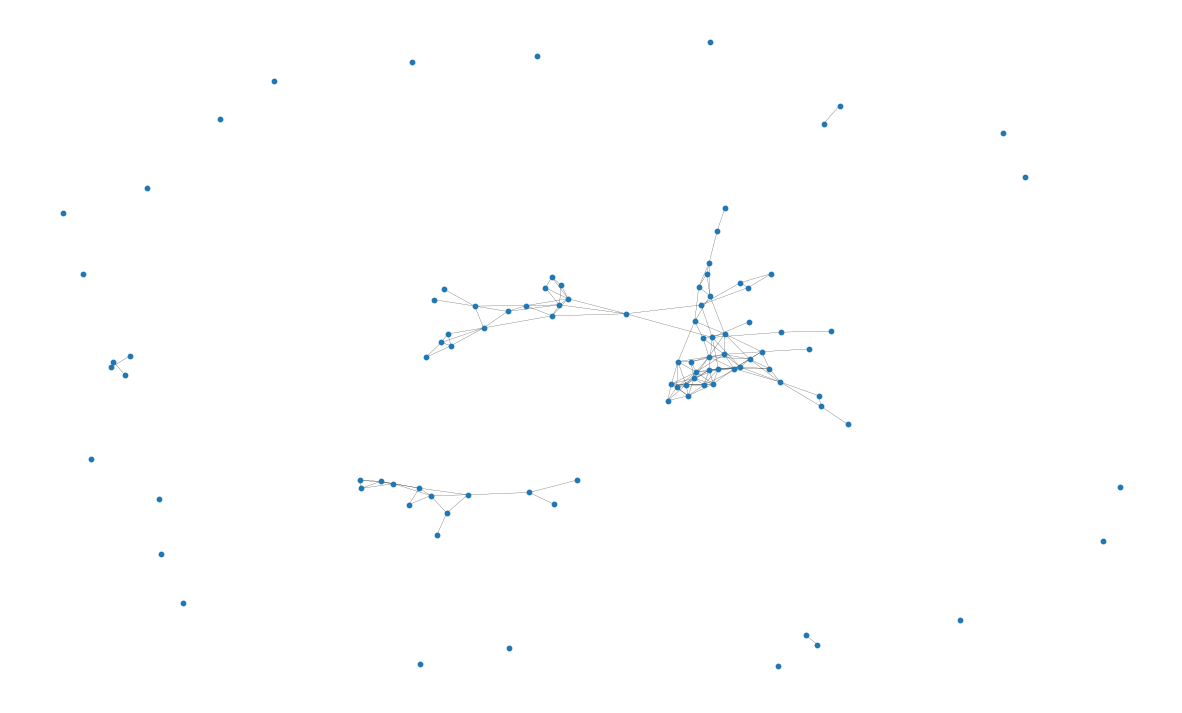

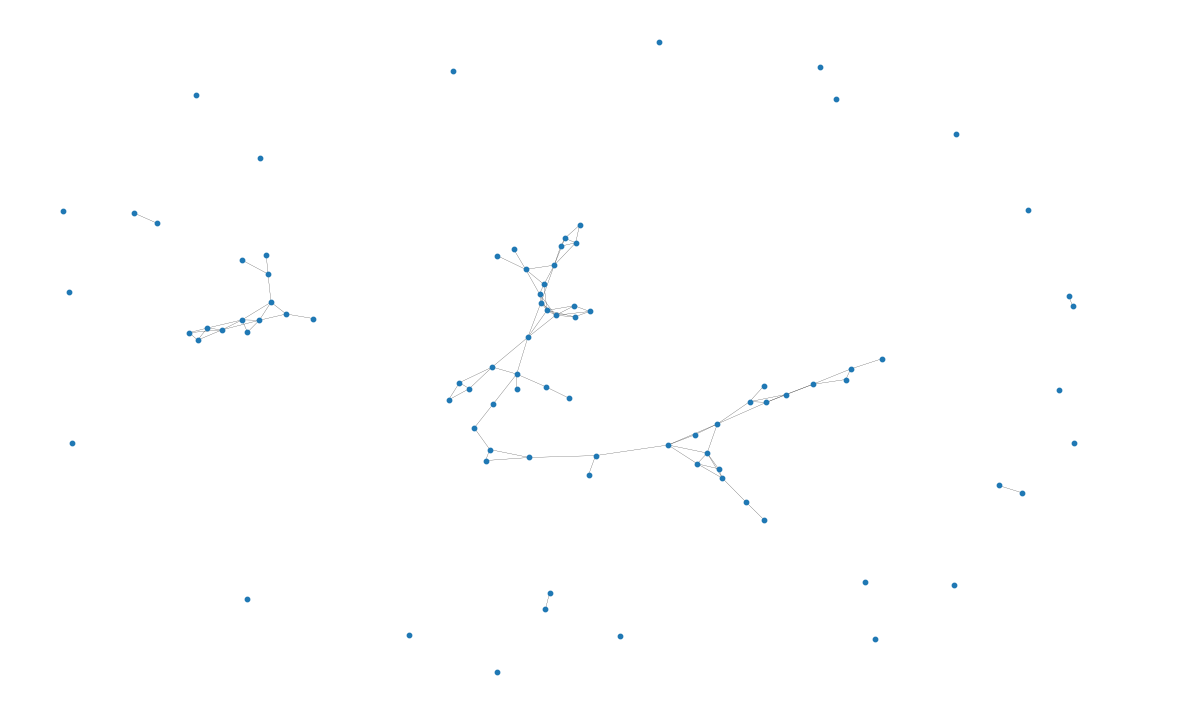

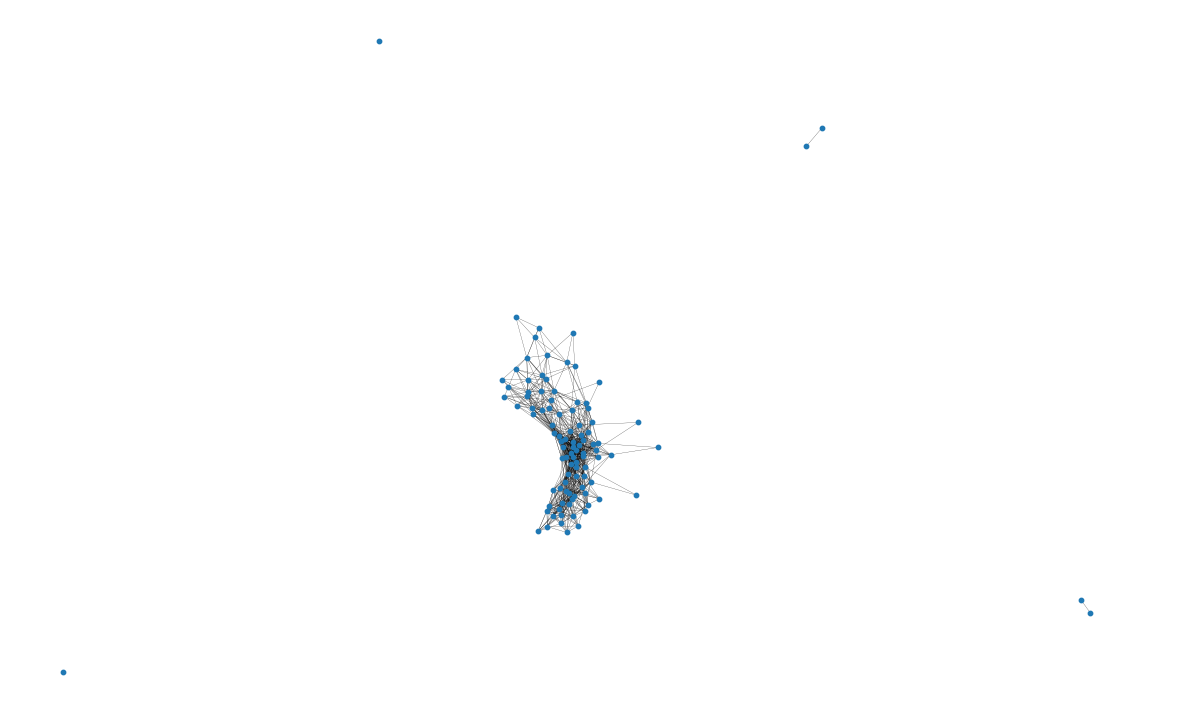

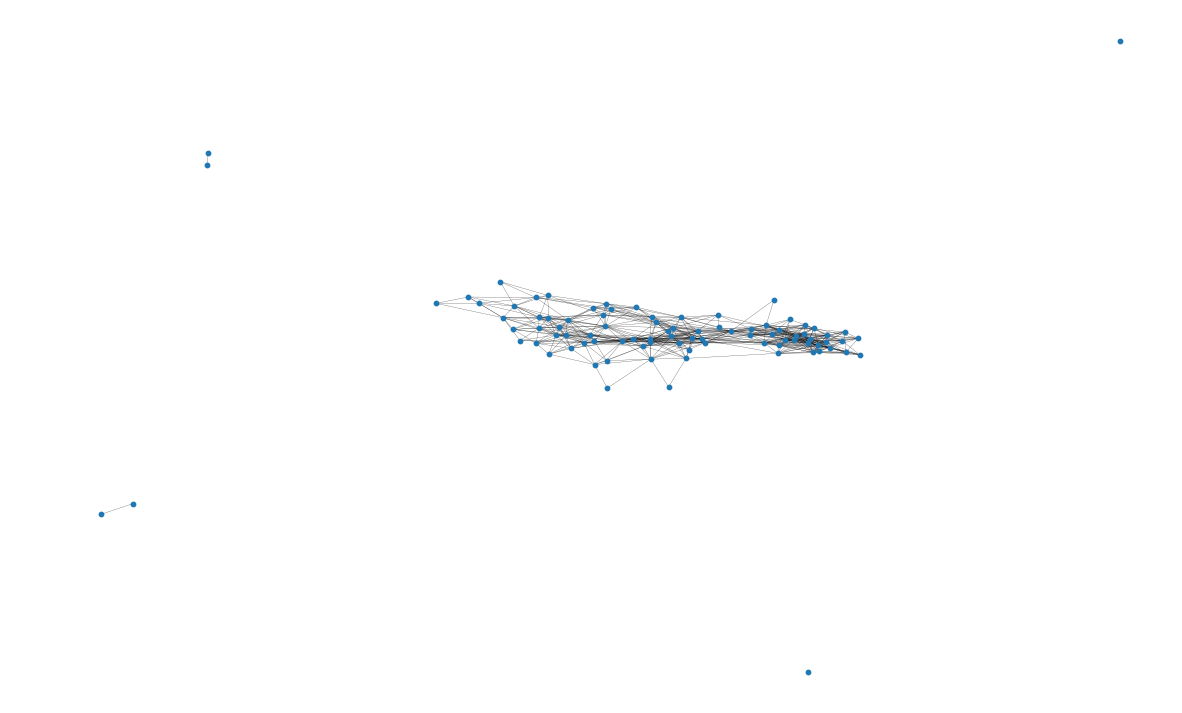

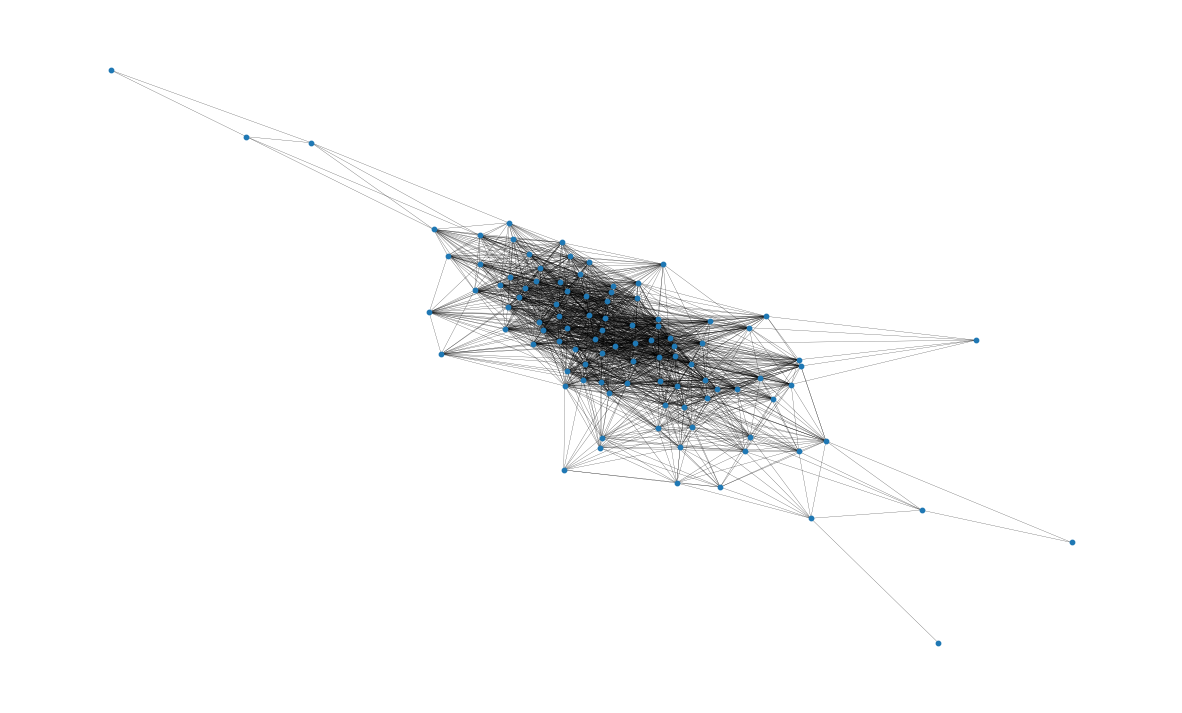

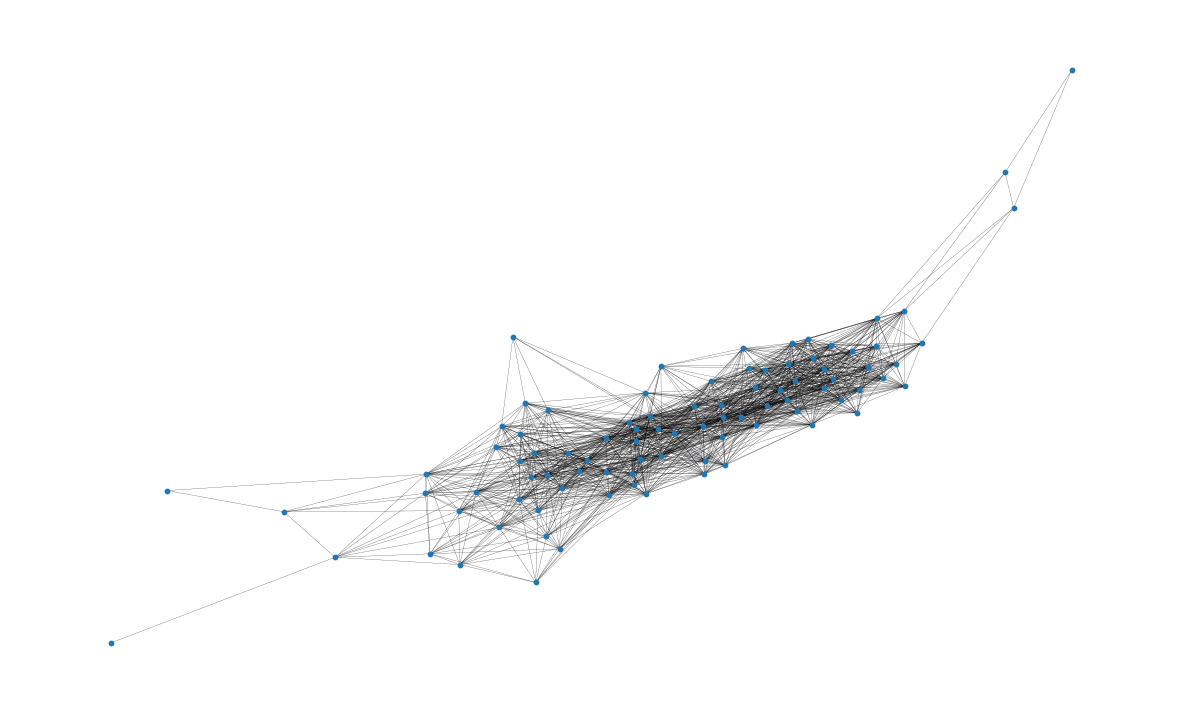

In [14]:
nb_de_noeuds = 10
graph1_minus_high_degree = delete_nodes(graph1.copy(), nb_de_noeuds)
graph2_minus_high_degree = delete_nodes(graph2.copy(), nb_de_noeuds)
graph3_minus_high_degree = delete_nodes(graph3.copy(), nb_de_noeuds)

afficher_graphe_avec_layout(graph1) #arc si distance < 20km
afficher_graphe_avec_layout(graph1_minus_high_degree) #arc si distance < 20km
afficher_graphe_avec_layout(graph2) #arc si distance < 40km
afficher_graphe_avec_layout(graph2_minus_high_degree) #arc si distance < 40km
afficher_graphe_avec_layout(graph3) #arc si distance < 60km
afficher_graphe_avec_layout(graph3_minus_high_degree) #arc si distance < 60km

In [18]:
graphes = [graph1, graph1_minus_high_degree, graph2, graph2_minus_high_degree, graph3, graph3_minus_high_degree]  # remplace par tes graphes réels
noms = ['Graphe <20km', 'Graphe <40km', 'Graphe <60']  # noms pour identification

# Liste pour stocker les résultats
donnees = []

# Boucle sur les graphes
for i in range (0, len(noms)):
    nb_arcs = graphes[i].number_of_edges()
    nb_arcs_after = graphes[i+1].number_of_edges()
    nb_noeuds = graphes[i].number_of_nodes()
    nb_noeuds_after = graphes[i+1].number_of_nodes()
    degre_moyen = np.mean([d for _, d in graphes[i].degree()])
    degre_moyen_after = np.mean([d for _, d in graphes[i+1].degree()])
    
    donnees.append({
        "Nom": noms[i],
        "Nombre d'arcs": nb_arcs,
        "Nombre d'arcs après suppression": nb_arcs_after,
        "Nombre de noeuds": nb_noeuds,
        "Nombre de noeuds après suppression": nb_noeuds_after,
        "Degré moyen des noeuds": degre_moyen,
        "Degré moyen des noeuds après suppression": degre_moyen_after
    })

# Création du DataFrame
result_hd = pd.DataFrame(donnees)

# Affichage
result_hd

,Nom,Nombre d'arcs,Nombre d'arcs après suppression,Nombre de noeuds,Nombre de noeuds après suppression,Degré moyen des noeuds,Degré moyen des noeuds après suppression
0,Graphe <20km,174,103,100,90,3.480000,2.288889
1,Graphe <40km,103,883,90,100,2.288889,17.660000
2,Graphe <60,883,587,100,90,17.660000,13.044444
